# This is a Stock Prediction exercise using Technical Analysis and Regression Techniques.

We shall use Historical Stock Data for Amazon downloaded from Yahoo Finance in this example

In [129]:
# We shall first download dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


In [130]:
df = pd.read_csv('AMZN.csv')

df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d') # Converts string to datetime
df = df.set_index('Date') # Set the index of dataframe to date column

df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-09-09,1841.000000,1850.000000,1824.609985,1831.349976,1831.349976,2999500
2019-09-10,1822.750000,1825.810059,1805.339966,1820.550049,1820.550049,2613900
2019-09-11,1812.140015,1833.420044,1809.079956,1822.989990,1822.989990,2432800
2019-09-12,1837.630005,1853.660034,1834.280029,1843.550049,1843.550049,2823500
2019-09-13,1842.010010,1846.119995,1835.170044,1839.339966,1839.339966,1951200


In [131]:
df.info()

# There does not appear to be any missing values..
# ..All the columns have 250 entries

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2018-09-17 to 2019-09-13
Data columns (total 6 columns):
Open         250 non-null float64
High         250 non-null float64
Low          250 non-null float64
Close        250 non-null float64
Adj Close    250 non-null float64
Volume       250 non-null int64
dtypes: float64(5), int64(1)
memory usage: 13.7 KB


# Plotting the Closing Price History of the Stock

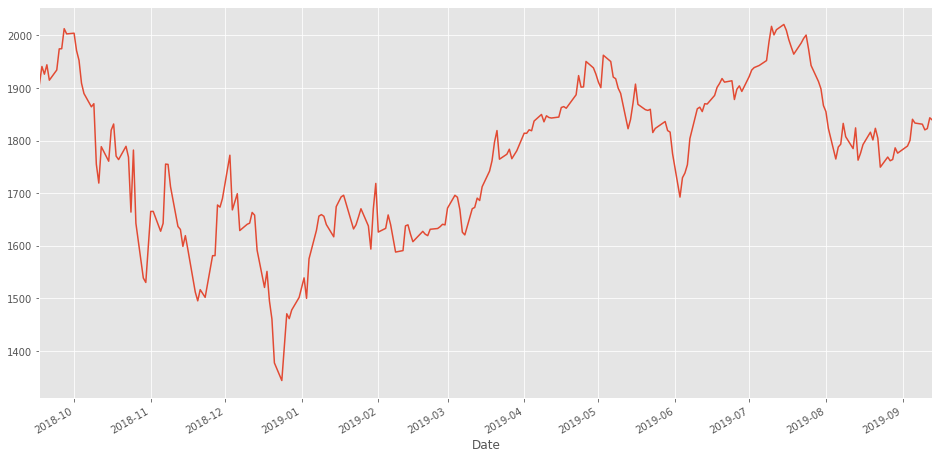

In [132]:
df['Adj Close'].plot(label="AMZN", figsize=(16, 8))

# Moving Average

In [133]:
# Rolling mean/Moving Average (MA) smooths out price data by creating a constantly updated average price. 
# This is useful to cut down “noise” in our price chart. 
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

In [134]:
mavg.tail()

Date
2019-09-09    1871.406600
2019-09-10    1870.963901
2019-09-11    1870.576902
2019-09-12    1870.139302
2019-09-13    1869.295001
Name: Adj Close, dtype: float64

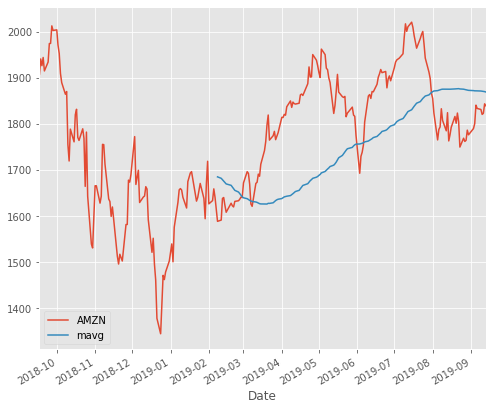

In [135]:
# For better understanding, let’s plot it out with Matplotlib. 
# We will overlay the Moving Average with our Stocks Price Chart.
from matplotlib import style

#Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8,7))
mpl.__version__

#Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AMZN')
mavg.plot(label='mavg')
plt.legend()

# The Moving Average makes the line smooth and displays increasing or decreasing trends

In [136]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,250.000000,250.000000,250.000000,250.000000,250.000000,2.500000e+02
mean,1770.955395,1789.339442,1748.323520,1769.245842,1769.245842,5.086421e+06
std,141.542259,135.336176,145.804803,140.670139,140.670139,2.374949e+06
min,1346.000000,1396.030029,1307.000000,1343.959961,1343.959961,1.690300e+06
25%,1656.079986,1675.522522,1627.010010,1656.309967,1656.309967,3.240600e+06
50%,1792.559998,1803.905029,1763.839966,1785.660034,1785.660034,4.513450e+06
75%,1881.562500,1899.142548,1860.199951,1870.942504,1870.942504,6.254450e+06
max,2025.619995,2035.800049,2003.869995,2020.989990,2020.989990,1.496380e+07


# Feature Engineering

In [137]:
dfreg = df.copy()
dfreg.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-09-17,1954.729980,1956.819946,1887.410034,1908.030029,1908.030029,7050200
2018-09-18,1918.650024,1958.199951,1915.439941,1941.050049,1941.050049,4268700
2018-09-19,1940.500000,1940.829956,1904.900024,1926.420044,1926.420044,4056800
2018-09-20,1938.579956,1955.000000,1932.250000,1944.300049,1944.300049,3154900
2018-09-21,1954.219971,1957.310059,1910.500000,1915.010010,1915.010010,6855900


In [138]:
df_feature = dfreg.loc[:, ['Adj Close', 'Volume']]
df_feature['HL_PCT'] = (dfreg['High'] - dfreg['Low'])/dfreg['Adj Close'] * 100.0
df_feature['PCT_Change'] = (dfreg['Adj Close'] - dfreg['Open']) / dfreg['Open'] * 100.0
df_feature.head()

,Adj Close,Volume,HL_PCT,PCT_Change
Date,,,,
2018-09-17,1908.030029,7050200,3.637779,-2.389074
2018-09-18,1941.050049,4268700,2.202932,1.167489
2018-09-19,1926.420044,4056800,1.865114,-0.725584
2018-09-20,1944.300049,3154900,1.170087,0.295066
2018-09-21,1915.010010,6855900,2.444377,-2.006425


In [139]:
from sklearn.preprocessing import MinMaxScaler

def normalize_data(df):
    min_max_scaler = MinMaxScaler()
    for col in df.columns:
      df[col] = min_max_scaler.fit_transform(df[col].values.reshape(-1,1))
    return df

df_feature_norm = normalize_data(df_feature)

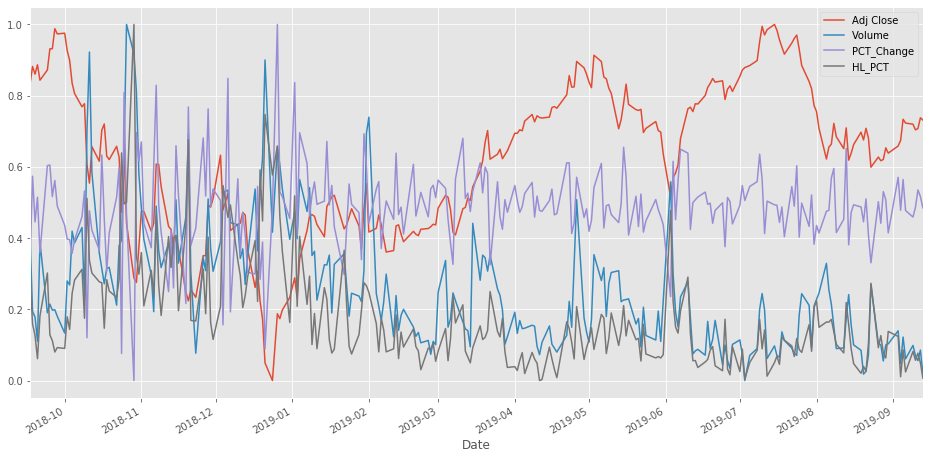

In [140]:
plt.figure(figsize=(16, 8))
df_feature_norm['Adj Close'].plot(label="Adj Close")
df_feature_norm['Volume'].plot(label="Volume")
df_feature_norm['PCT_Change'].plot(label="PCT_Change")
df_feature_norm['HL_PCT'].plot(label="HL_PCT")
plt.legend(loc="best")

# Splitting the dataset
We can not randomly split time series data, since the sequence matters.

In [141]:
def create_dataset(window, df, val=" "):
  # window here refers to days we are taking the data before the window gap
  # then pushing them one by one a day ahead
  sample_size = len(df) - window
  index = np.arange(sample_size).astype('int').reshape(-1, 1) + np.arange(window+1).astype('int')
  data = df[val].values[index]
  return data

In [142]:
data = create_dataset(31, df, 'Adj Close')
data

array([[1908.030029, 1941.050049, 1926.420044, ..., 1642.810059,
        1538.880005, 1530.420044],
       [1941.050049, 1926.420044, 1944.300049, ..., 1538.880005,
        1530.420044, 1598.01001 ],
       [1926.420044, 1944.300049, 1915.01001 , ..., 1530.420044,
        1598.01001 , 1665.530029],
       ...,
       [1912.449951, 1898.530029, 1866.780029, ..., 1831.349976,
        1820.550049, 1822.98999 ],
       [1898.530029, 1866.780029, 1855.319946, ..., 1820.550049,
        1822.98999 , 1843.550049],
       [1866.780029, 1855.319946, 1823.23999 , ..., 1822.98999 ,
        1843.550049, 1839.339966]])

In [143]:
# Time to split the data, but we can't split it randomly because it's a time series data

# leaving the 45th day farecasts
X = data[:, :-1]
# value of stock price on 45th day
y = data[:, -1]

window = 31

sample_size = len(df) - window
per = 0.8
split_per = int(per * sample_size)


X_train = X[:split_per]
X_test = X[split_per:]
y_train = y[:split_per]
y_test = y[split_per:]

# Training the models

In [144]:
def plot_forecast(df, model, X_train, X_test, y_train, y_test, split_type="train"):
  model.fit(X_train, y_train)
  train = model.predict(X_train)
  test = model.predict(X_test)
  window  = 31
  sample_size = len(df) - window
  per = 0.8
  split_per = int(per * sample_size)
  if split_type == "train":
    data = df.copy()
    data.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
    # 31 days prior data before forecast
    data = data.iloc[window:split_per]
    data['Adj Close Train'] = train[:-window]
    data.plot(label='AMZN', figsize=(16, 8), title='Adjusted Closing Price', grid=True)
  else:
    data = df.copy()
    data.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
    data = data.iloc[window + split_per:]
    data['Adj Close Test'] = test
    data.plot(label='AMZN', figsize=(16, 8), title='Adjusted Closing Price', grid=True)

# Linear Regression

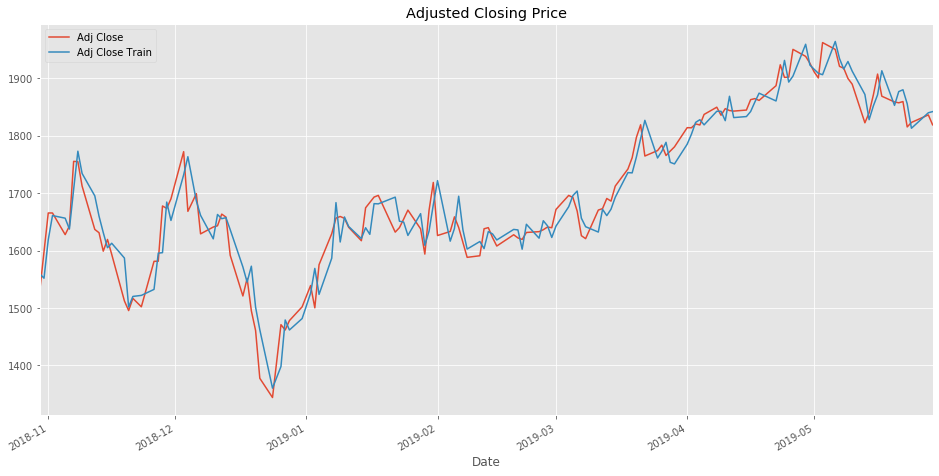

In [145]:
lr = LinearRegression()
plot_forecast(df, lr, X_train, X_test, y_train, y_test, split_type="train")

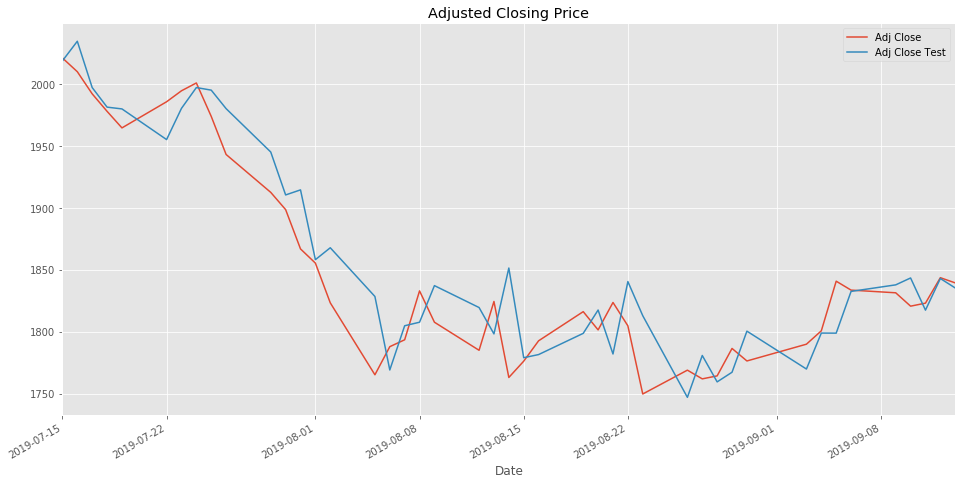

In [146]:
plot_forecast(df, lr, X_train, X_test, y_train, y_test, split_type="test")

# Ridge Regressor

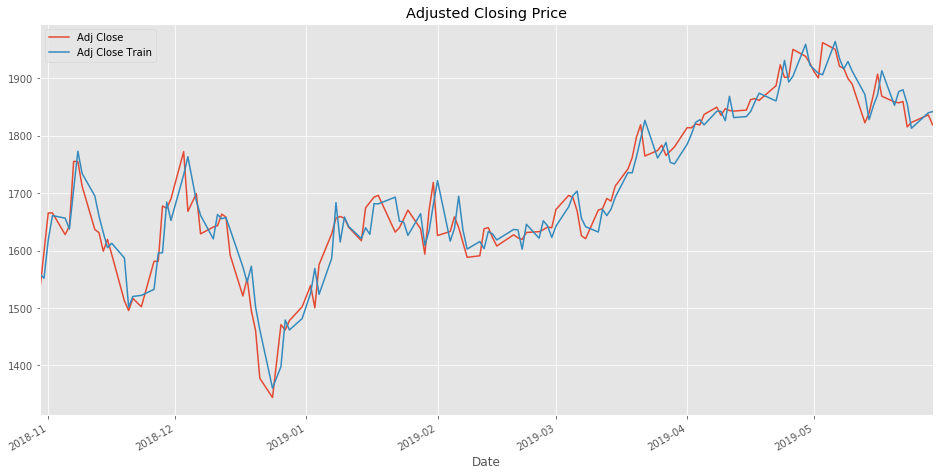

In [147]:
ridge = Ridge()

plot_forecast(df, ridge, X_train, X_test, y_train, y_test, split_type="train")

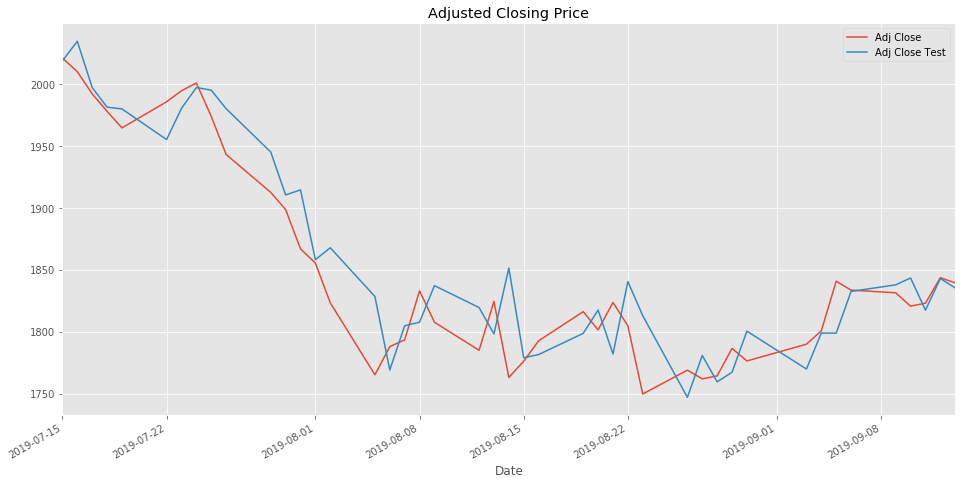

In [148]:
plot_forecast(df, ridge, X_train, X_test, y_train, y_test, split_type="test")

# K Neighbors Regressor

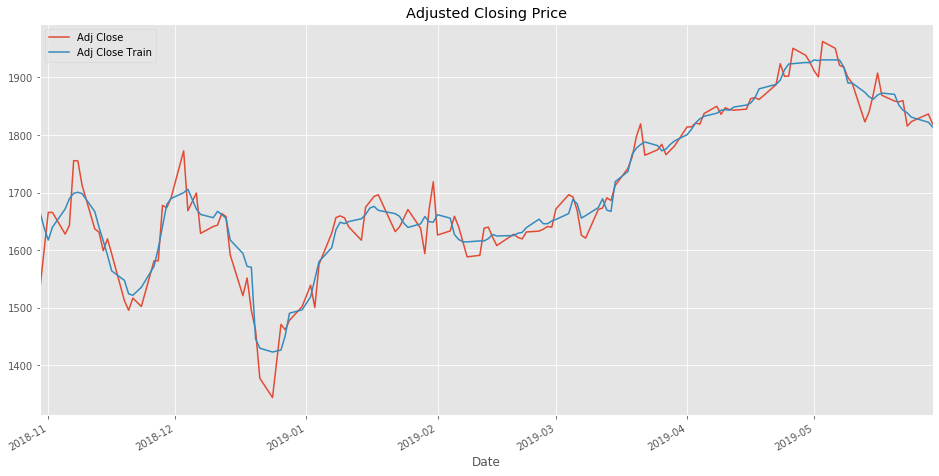

In [149]:
knn_reg = KNeighborsRegressor(n_neighbors=5)

plot_forecast(df, knn_reg, X_train, X_test, y_train, y_test, split_type="train")

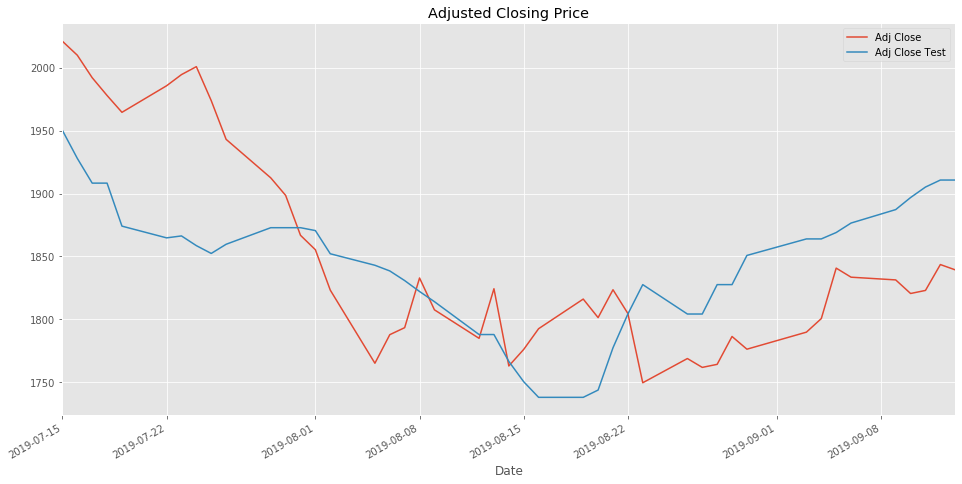

In [150]:
plot_forecast(df, knn_reg, X_train, X_test, y_train, y_test, split_type="test")

# Gradient Boosting

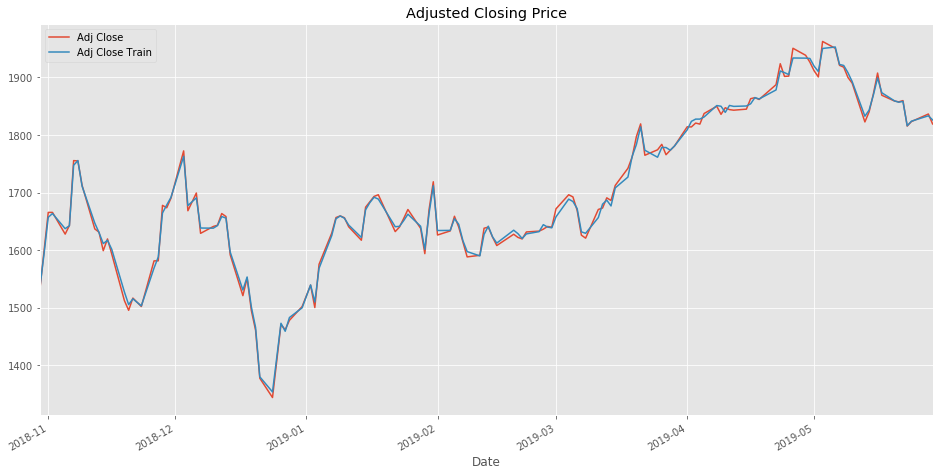

In [151]:
from sklearn.ensemble import GradientBoostingRegressor

rnd = GradientBoostingRegressor(n_estimators=100)
plot_forecast(df, rnd, X_train, X_test, y_train, y_test, split_type="train")

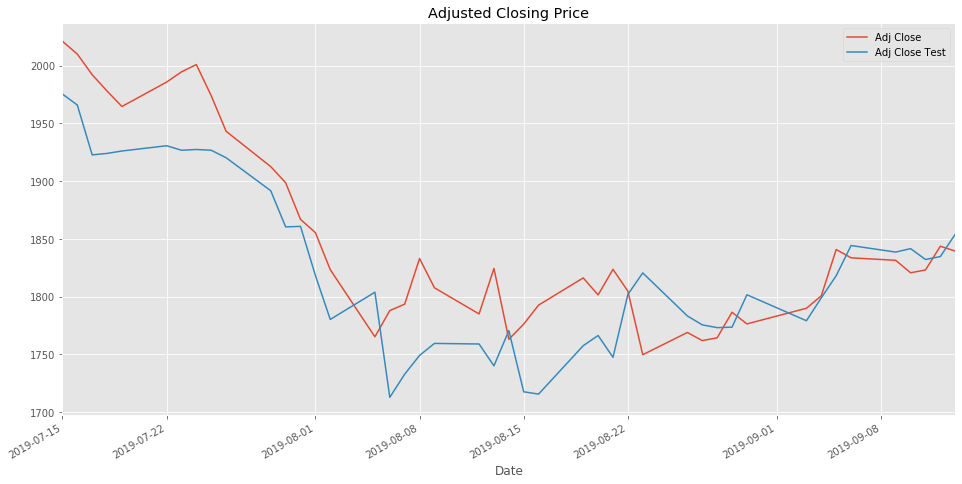

In [152]:
plot_forecast(df, rnd, X_train, X_test, y_train, y_test, split_type="test")

In [153]:
lr = LinearRegression().fit(X_train, y_train)
ridge = Ridge().fit(X_train, y_train)
knn_reg = KNeighborsRegressor().fit(X_train, y_train)
gb = GradientBoostingRegressor().fit(X_train, y_train)

y_train_pred_lr = lr.predict(X_train)
y_test_pred_lr = lr.predict(X_test)

y_train_pred_ridge = ridge.predict(X_train)
y_test_pred_ridge = ridge.predict(X_test)

y_train_pred_knn = knn_reg.predict(X_train)
y_test_pred_knn = knn_reg.predict(X_test)

y_train_pred_gb = gb.predict(X_train)
y_test_pred_gb = gb.predict(X_test)

In [154]:
df_train = df.copy()
df_train.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_train = df_train.iloc[window:split_per] # Past 32 days we don't know yet
# Add in all of our methods

df_train['Adj Close Train LR'] = y_train_pred_lr[:-window]
df_train['Adj Close Train Ridge'] = y_train_pred_ridge[:-window]
df_train['Adj Close Train KNN'] = y_train_pred_knn[:-window]
df_train['Adj Close Train GB'] = y_train_pred_gb[:-window]

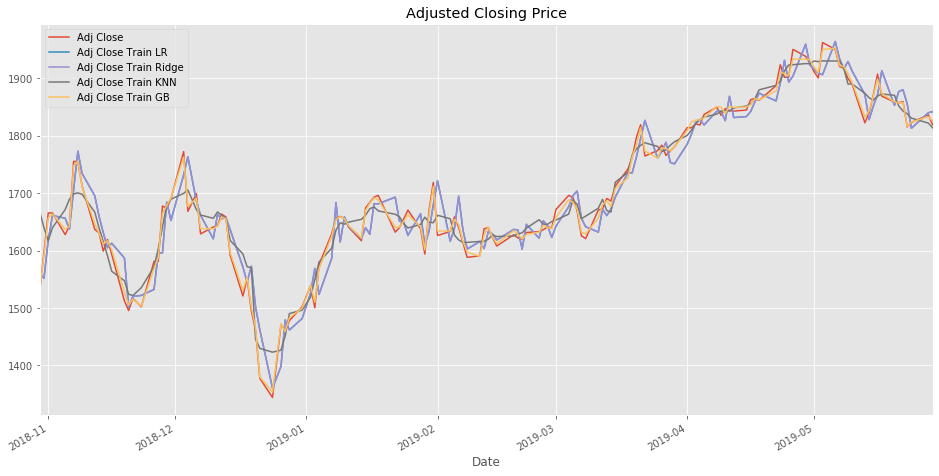

In [155]:
df_train.plot(label='AMZN', figsize=(16,8), title='Adjusted Closing Price', grid=True)
plt.legend(loc="best")

In [157]:
df_test = df.copy()
df_test.drop(['Open','Low', 'High', 'Close', 'Volume'], axis=1, inplace=True)
df_test = df_test.iloc[window+split_per:]

df_test['LR Test'] = y_test_pred_lr
df_test['Ridge Test'] = y_test_pred_ridge
df_test['KNN Test'] = y_test_pred_knn
df_test['GB Test'] = y_test_pred_gb

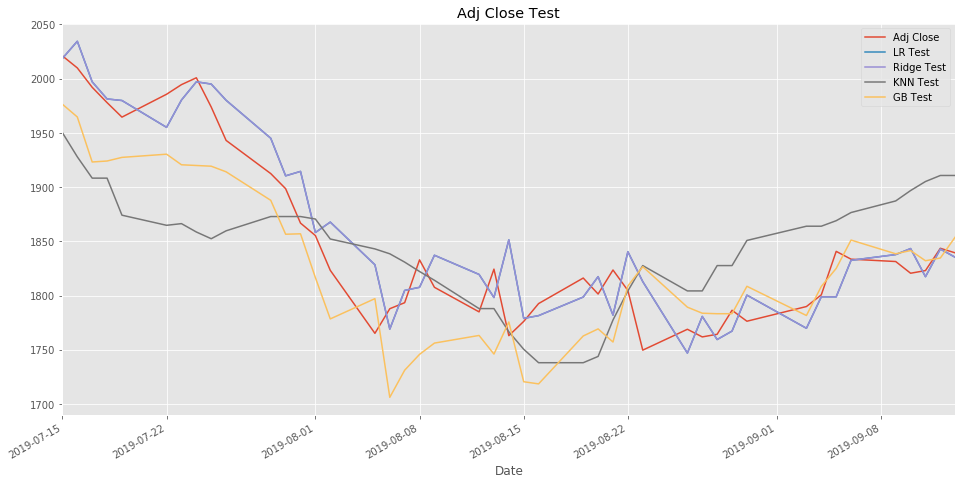

In [158]:
df_test.plot(figsize=(16, 8), title="Adj Close Test")